# Machine Learning On Marble

This tutorial seeks to outline the steps typically taken in building a machine learning model. You will be introduced to terms and common libraries used for model building. 

Before diving into any machine learning endeavor, it's crucial to grasp a clear understanding of the target variables you aim to predict or map. In this context, our goal is to uncover which atmospheric variables hold the most influence in predicting the total monthly surface precipitation in Singapore. Given that precipitation is a continuous value, the nature of our task aligns with a regression model. 

To embark on this journey, let's kick things off by importing the essential libraries needed to conduct our analysis.

In [1]:
#scientific computing
import numpy as np
import pandas as pd
import xarray as xr
import pooch
from matplotlib import pyplot as plt
%matplotlib inline

#mapping
import cartopy.crs as ccrs
import cartopy as cp
import cartopy.feature as cfeature

#EDA
from ydata_profiling import ProfileReport

#filter warnings
import warnings
warnings.filterwarnings('ignore')

#time
from datetime import datetime

#models
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor, AdaBoostRegressor

#metrics and model tuning
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

#random_state / random_seed
seed = 0

Among the familiar tools like `numpy` and `xarray`, you'll discover a league of powerful newcomers: `xgboost`, `sklearn`, `lightgbm`, and `catboost`. These libraries hold the keys to the world of gradient boosting tree models. Imagine these models as a band of specialists, each refining its craft to mend the errors made by its predecessors. It's like building an army of sharp minds where each new recruit shores up the weaknesses of the previous ones. Together, they create an ensemble model that's far mightier than any individual learner. After all, when it comes to creating impactful models, strength truly lies in numbers!
<br>
<br>

### Loading Data

In [2]:
%%time
data_dict={'tas':'https://daccs.cs.toronto.edu/twitcher/ows/proxy/thredds/fileServer/datasets/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/Amon/tas/gn/v20190514/tas_Amon_CESM2_historical_r11i1p1f1_gn_185001-201412.nc',
           'psl':'https://daccs.cs.toronto.edu/twitcher/ows/proxy/thredds/fileServer/datasets/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/Amon/psl/gn/v20190514/psl_Amon_CESM2_historical_r11i1p1f1_gn_185001-201412.nc',
           'pr':'https://daccs.cs.toronto.edu/twitcher/ows/proxy/thredds/fileServer/datasets/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/Amon/pr/gn/v20190514/pr_Amon_CESM2_historical_r11i1p1f1_gn_185001-201412.nc',
           'huss':'https://daccs.cs.toronto.edu/twitcher/ows/proxy/thredds/fileServer/datasets/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/Amon/huss/gn/v20190514/huss_Amon_CESM2_historical_r11i1p1f1_gn_185001-201412.nc',
           'hurs':'https://daccs.cs.toronto.edu/twitcher/ows/proxy/thredds/fileServer/datasets/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/Amon/hurs/gn/v20190514/hurs_Amon_CESM2_historical_r11i1p1f1_gn_185001-201412.nc',
           'clt':'https://daccs.cs.toronto.edu/twitcher/ows/proxy/thredds/fileServer/datasets/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/Amon/clt/gn/v20190514/clt_Amon_CESM2_historical_r11i1p1f1_gn_185001-201412.nc'
    
}

data_paths = {}
for variable, url in data_dict.items():
    path = pooch.retrieve(url, known_hash=None)
    data_paths[variable] = path
    
data_paths


CPU times: user 552 µs, sys: 1.13 ms, total: 1.69 ms
Wall time: 1.26 ms


{'tas': '/home/jovyan/.cache/pooch/2e6aa3d311a810a2e568c56910e8c7f3-tas_Amon_CESM2_historical_r11i1p1f1_gn_185001-201412.nc',
 'psl': '/home/jovyan/.cache/pooch/55a2f0c6b1eec6b87f61bea0c8f42bac-psl_Amon_CESM2_historical_r11i1p1f1_gn_185001-201412.nc',
 'pr': '/home/jovyan/.cache/pooch/1910086169d33e6536538196b07a41b1-pr_Amon_CESM2_historical_r11i1p1f1_gn_185001-201412.nc',
 'huss': '/home/jovyan/.cache/pooch/39ad9111eaf9d3a09ec78f48697f679d-huss_Amon_CESM2_historical_r11i1p1f1_gn_185001-201412.nc',
 'hurs': '/home/jovyan/.cache/pooch/8d3d8e88e8bc674f79ece1924eca3777-hurs_Amon_CESM2_historical_r11i1p1f1_gn_185001-201412.nc',
 'clt': '/home/jovyan/.cache/pooch/4e9fc634b3f7956b2499e90edbe04832-clt_Amon_CESM2_historical_r11i1p1f1_gn_185001-201412.nc'}

Here, we retrieve our data from a THREDDS server and organize it into a dictionary. This dictionary pairs variable names with their respective data file locations. Leveraging this setup, we employ `xarray.open_mfdataset` to efficiently load and merge these files into a single dataset, simplifying data manipulation.

In [3]:
%%time

#opening psl
data = xr.open_mfdataset(data_paths.values())
data

CPU times: user 28.7 s, sys: 3.35 s, total: 32 s
Wall time: 28.5 s


<xarray.Dataset>
Dimensions:    (time: 1980, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    clt        (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    time_bnds  (time, nbnd) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
    hurs       (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    huss       (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    psl        (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    sub_experiment_id:      none
    table_id:               Amon
    variable_id:            clt
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1
    history:                This file was generated on Fri Nov  3 21:15:57 20...

You might have observed a distinctive aspect of this xarray dataset. The `xarray.open_mfdataset` seamlessly integrates with the `dask` library, specifically designed for handling big data computations. This function conveniently partitions your data into manageable chunks, preventing the need to load the entire set into memory simultaneously. This approach significantly improves resource management.

Let's visualise our dataset to get a better idea of our variables. 

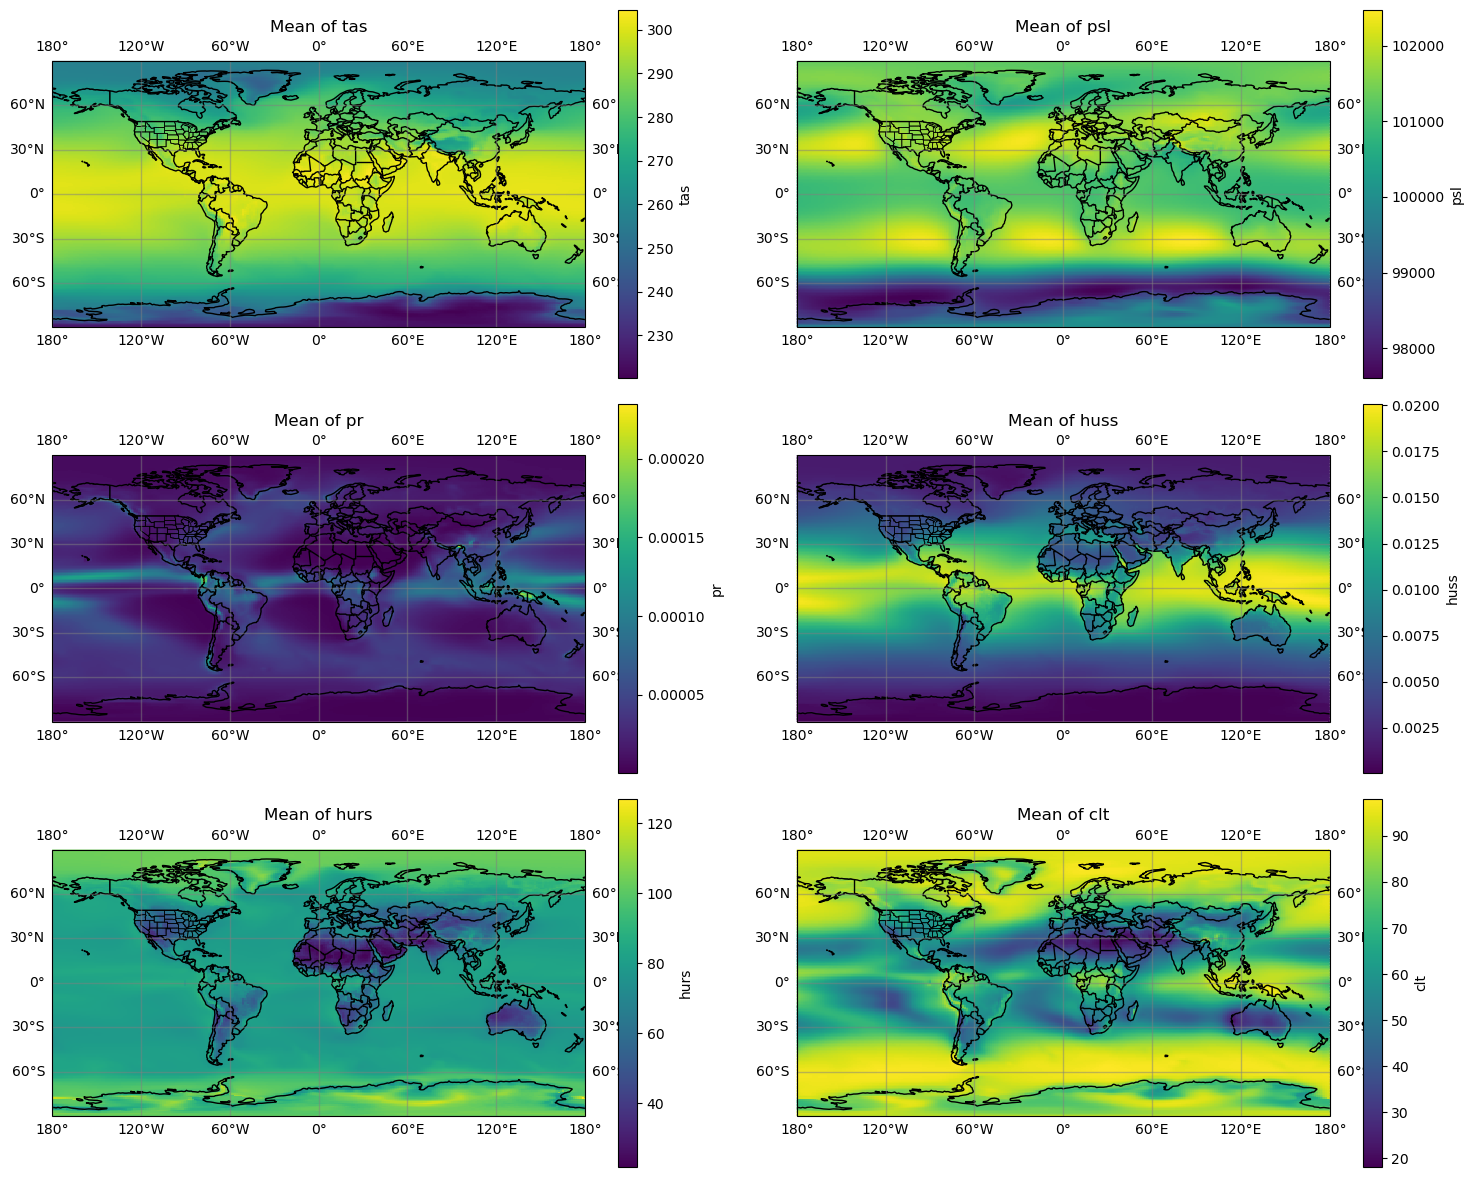

CPU times: user 45 s, sys: 3.35 s, total: 48.4 s
Wall time: 30.6 s


In [4]:
%%time
#make a list of variables to plot
vars = list(data_paths.keys())

plt.figure(figsize=(15,12))

# Flatten the axes array to iterate over each subplot
#axes = axes.flatten()

# Iterate over the variables
for i, var in enumerate(vars):
    ax = plt.subplot(3,2,i+1, projection=ccrs.PlateCarree())
   # ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Plot states & borders
    ax.add_feature(cp.feature.STATES, edgecolor='black', linewidth=0.5)
    ax.add_feature(cp.feature.BORDERS, edgecolor='black', linewidth=1)
    ax.coastlines()

    data[var].mean(dim='time').plot(ax=ax, transform=ccrs.PlateCarree())
    ax.set_title(f"Mean of {var}")

    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='-')
    
plt.tight_layout()
plt.show()

This analysis provides valuable insights into each variable's distribution:

1. **`tas`:** Indicates a consistent decrease in temperature moving towards the poles.
2. **`psl`:** Illustrates the locations of high-pressure zones across the surface.
3. **`pr`:** Reveals persistent high rainfall around the equator and on the eastern and northern peripheries of high-pressure zones.
4. **`huss`:** Highest in the tropics, indicating regions where the air can retain more water vapor.
5. **`hurs`:** Demonstrates lower average values over continents along high-pressure belts.
6. **`clt`:** Shows a similar distribution to `hurs`, with fewer clouds in areas with lower humidity and/or higher pressure.

This understanding helps in interpreting the climatic conditions and dynamics across different geographical regions.

However, we are not interested in that, what we want to know is which of these variables have the greatest power in predicting precipitation over Singapore over time. 

In [5]:
%%time
#singapore coordinates
lat = 1.3521
lon = 1.3521

singapore = data[vars].sel(lat=lat, lon=lon, method='nearest')
singapore

CPU times: user 21.8 ms, sys: 367 µs, total: 22.2 ms
Wall time: 21.2 ms


<xarray.Dataset>
Dimensions:  (time: 1980)
Coordinates:
    lat      float64 1.414
    lon      float64 1.25
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
Data variables:
    tas      (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    psl      (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    pr       (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    huss     (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    hurs     (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    clt      (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    sub_experiment_id:      none
    table_id:               Amon
    variable_id:            clt
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1
    history:                This file was generated on Fri Nov  3 21:15:57 20...

We've focused on selecting the nearest data point to our specified location for the variables of interest. You might wonder why not take a global approach? The reason is straightforward: tree models operate within a 2D space, making the preparation of a higher-dimensional dataset beyond the scope of this tutorial. More comprehensive techniques will be covered in subsequent tutorials to handle higher dimensions effectively.

Let's take a look at the metadata for each variable.

### Manipulating Data

In [6]:
%%time

#take a look at the units of variables
for variable in singapore.variables:

    #get units and variable description
    units = singapore[variable].attrs.get('units')
    description = singapore[variable].attrs.get('description')

    #write data to metadata txt file
    with open('singapore_metadata.txt', 'a+') as file:
        file.write(f"{variable} is {description} measured in {units}. \n\n")

    #print information
    print(f"{variable} is {description} measured in {units}.")
    print()


tas is near-surface (usually, 2 meter) air temperature measured in K.

psl is not, in general, the same as surface pressure measured in Pa.

pr is at surface; includes both liquid and solid phases from all types of clouds (both large-scale and convective) measured in kg m-2 s-1.

huss is Near-surface (usually, 2 meter) specific humidity. measured in 1.

hurs is This is the relative humidity with respect to liquid water for T> 0 C, and with respect to ice for T<0 C. measured in %.

clt is for the whole atmospheric column, as seen from the surface or the top of the atmosphere. Include both large-scale and convective cloud. measured in %.

lat is None measured in degrees_north.

lon is None measured in degrees_east.

time is None measured in None.

CPU times: user 0 ns, sys: 1.01 ms, total: 1.01 ms
Wall time: 805 µs


As we convert the data from an xarray dataset to a dataframe, some information loss is anticipated. To preserve vital metadata about our variables, we've maintained this information in a text file for future reference if needed.

Now let's convert our dataset to a 'pandas` dataframe for easier manipulation.

In [7]:
%%time

sing_df = singapore.to_dataframe()
sing_df = sing_df.drop(['lat','lon'], axis=1)
sing_df

CPU times: user 32.7 s, sys: 1.87 s, total: 34.6 s
Wall time: 31.5 s


tas            psl        pr      huss       hurs  \
time                                                                            
1850-01-15 12:00:00  300.332672  100981.664062  0.000031  0.018161  80.826218   
1850-02-14 00:00:00  301.102051  100931.570312  0.000020  0.018143  77.156830   
1850-03-15 12:00:00  301.172913  100871.906250  0.000053  0.019471  82.353477   
1850-04-15 00:00:00  301.175446  101016.468750  0.000035  0.019206  81.336685   
1850-05-15 12:00:00  300.771332  100964.578125  0.000042  0.019539  84.693420   
...                         ...            ...       ...       ...        ...   
2014-08-15 12:00:00  299.182434  101339.984375  0.000002  0.016927  80.921547   
2014-09-15 00:00:00  299.601135  101311.554688  0.000002  0.017491  81.500290   
2014-10-15 12:00:00  300.147461  101159.484375  0.000004  0.017855  80.409378   
2014-11-15 00:00:00  300.769775  101101.570312  0.000074  0.019193  83.324203   
2014-12-15 12:00:00  300.938385  101096.953125  0.000033  0.019048  81.893417   

                           clt  
time                            
1850-01-15 12:00:00  67.595139  
1850-02-14 00:00:00  69.740829  
1850-03-15 12:00:00  75.408829  
1850-04-15 00:00:00  69.285049  
1850-05-15 12:00:00  69.559113  
...                        ...  
2014-08-15 12:00:00  63.258583  
2014-09-15 00:00:00  65.061989  
2014-10-15 12:00:00  47.490864  
2014-11-15 00:00:00  61.768677  
2014-12-15 12:00:00  70.255272  

[1980 rows x 6 columns]

In [8]:
#reset the index of the dataframe
sing_df = sing_df.reset_index()

sing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980 entries, 0 to 1979
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    1980 non-null   object 
 1   tas     1980 non-null   float32
 2   psl     1980 non-null   float32
 3   pr      1980 non-null   float32
 4   huss    1980 non-null   float32
 5   hurs    1980 non-null   float32
 6   clt     1980 non-null   float32
dtypes: float32(6), object(1)
memory usage: 62.0+ KB


Now that the dataset has been transformed into a dataframe, we're poised to start exploring and refining the data as needed. One notable observation is that the time information is currently stored as an object rather than in a datetime format. Let's see how we can change this.

In [9]:
%%time

sing_df.time = sing_df.time.astype(str)
sing_df.time = pd.to_datetime(sing_df.time)

sing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980 entries, 0 to 1979
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1980 non-null   datetime64[ns]
 1   tas     1980 non-null   float32       
 2   psl     1980 non-null   float32       
 3   pr      1980 non-null   float32       
 4   huss    1980 non-null   float32       
 5   hurs    1980 non-null   float32       
 6   clt     1980 non-null   float32       
dtypes: datetime64[ns](1), float32(6)
memory usage: 62.0 KB
CPU times: user 38.8 ms, sys: 0 ns, total: 38.8 ms
Wall time: 38.5 ms


Addressing data irregularities is of utmost importance before delving into advanced model building. It's crucial to meticulously handle data types, address missing values, and ensure accurate data representations. In machine learning, always remember: 'garbage in, garbage out!'

### Exploratory Data Analysis

Let's start by visualising how our variables change with time.

In [10]:
sing_time = sing_df.set_index('time')
sing_time.head()

tas            psl        pr      huss       hurs  \
time                                                                            
1850-01-15 12:00:00  300.332672  100981.664062  0.000031  0.018161  80.826218   
1850-02-14 00:00:00  301.102051  100931.570312  0.000020  0.018143  77.156830   
1850-03-15 12:00:00  301.172913  100871.906250  0.000053  0.019471  82.353477   
1850-04-15 00:00:00  301.175446  101016.468750  0.000035  0.019206  81.336685   
1850-05-15 12:00:00  300.771332  100964.578125  0.000042  0.019539  84.693420   

                           clt  
time                            
1850-01-15 12:00:00  67.595139  
1850-02-14 00:00:00  69.740829  
1850-03-15 12:00:00  75.408829  
1850-04-15 00:00:00  69.285049  
1850-05-15 12:00:00  69.559113

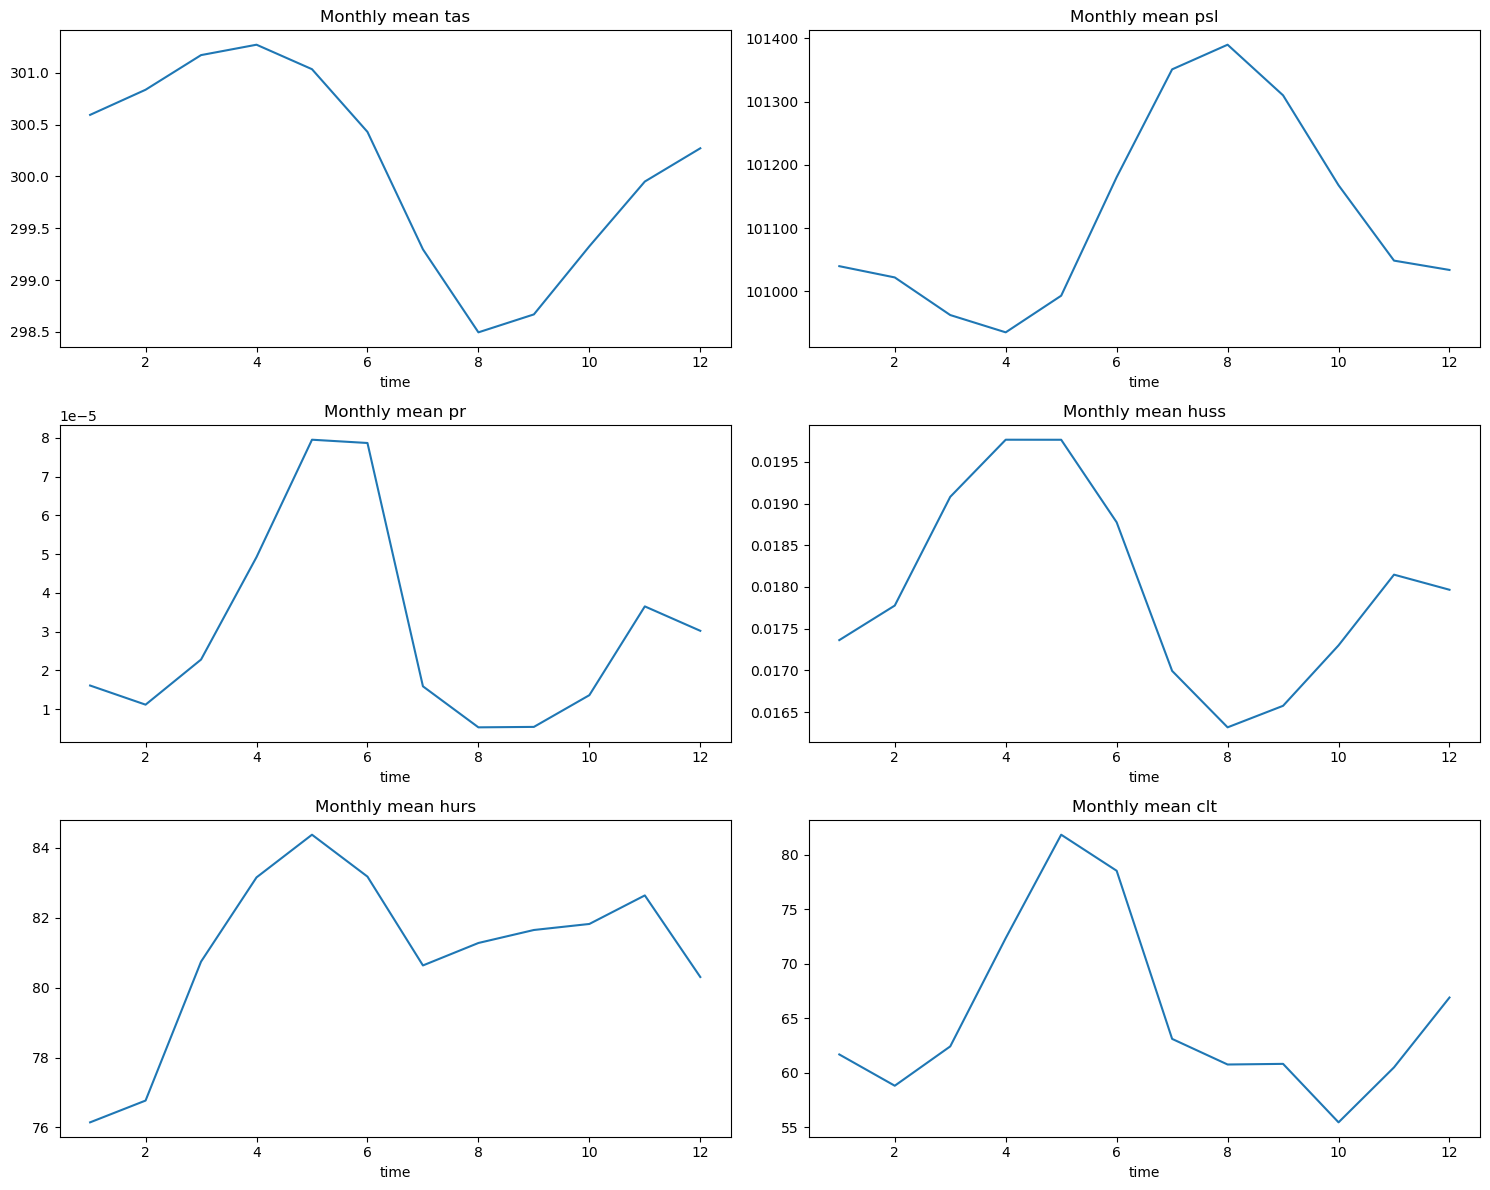

CPU times: user 890 ms, sys: 396 ms, total: 1.29 s
Wall time: 795 ms


In [11]:
%%time
###
cols = list(sing_time.columns)

plt.figure(figsize=(15,12))

for i, var in enumerate(cols):
    ax = plt.subplot(3,2,i+1)
    sing_time[var].groupby(sing_time.index.month).mean().plot(ax=ax)
    ax.set_title(f"Monthly mean {var}")
    #ax.set_xlim(1,365)

plt.tight_layout()
plt.show()

Initially, our dataset encapsulated monthly averages spanning 164 years. By calculating the mean values for each month across this timeline, we aimed to uncover any discernible patterns.<br>

The plots reveal an intriguing trend: notably, precipitation spikes align with months exhibiting higher temperatures, humidity levels, and increased cloud cover. While this correlation might seem evident to seasoned climate researchers, it highlights potential underlying interactions between these variables when viewed through the lens of machine learning.

Moreover, the month itself emerges as a pivotal factor in predicting these variables. Therefore, let's derive a new column dedicated to housing this data.

In [12]:
#making a new column
sing_time['month'] = sing_time.index.month
sing_time.head()

tas            psl        pr      huss       hurs  \
time                                                                            
1850-01-15 12:00:00  300.332672  100981.664062  0.000031  0.018161  80.826218   
1850-02-14 00:00:00  301.102051  100931.570312  0.000020  0.018143  77.156830   
1850-03-15 12:00:00  301.172913  100871.906250  0.000053  0.019471  82.353477   
1850-04-15 00:00:00  301.175446  101016.468750  0.000035  0.019206  81.336685   
1850-05-15 12:00:00  300.771332  100964.578125  0.000042  0.019539  84.693420   

                           clt  month  
time                                   
1850-01-15 12:00:00  67.595139      1  
1850-02-14 00:00:00  69.740829      2  
1850-03-15 12:00:00  75.408829      3  
1850-04-15 00:00:00  69.285049      4  
1850-05-15 12:00:00  69.559113      5

Each row in our dataset corresponds to the specific month when the data was recorded. To accelerate our exploratory data analysis (EDA), we'll utilize `ydata_profiling`. This tool seamlessly integrates with `pandas`, generating comprehensive reports that delve into the statistical properties of each column along with potential interactions. While this approach significantly accelerates the model-building process, it's essential to note that for exceedingly large datasets, this method can be computationally intensive and time-consuming.

For a deeper dive into `ydata_profiling`, I encourage exploring its comprehensive [documentation](https://docs.profiling.ydata.ai/latest/).

In [13]:
sing_report = ProfileReport(sing_time)
sing_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

It is also possible to save your profile as an html file for later reviewing using the `to_file()` function.

```
sing_report.to_file(output_file='singapore_report.html')
```

### Model Building

With EDA finished and new featured engineered, as required, we can proceed to building our model. 
This means processing our data into a form that can be accepted by a model. 

In [14]:
#function to build model and split data and scale

def preprocess(dataframe, target_var, test_size=0.2):

    #defining x and y vars
    X_vars = dataframe.drop([target_var], axis=1)
    Y_var = dataframe[[target_var]]
    

    #train test split
    x_train, x_test, y_train, y_test = train_test_split(X_vars, Y_var, test_size = test_size, shuffle=False)

    #store months before normalising data
    train_months = x_train['month'].reset_index(drop=True)
    test_months = x_test['month'].reset_index(drop=True)
    x_train = x_train.drop(columns='month')
    x_test = x_test.drop(columns='month')

    #get columns
    X_cols = x_train.columns


    #normalisation
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    test_scaler = MinMaxScaler()
    y_train = test_scaler.fit_transform(y_train)
    y_test = test_scaler.transform(y_test)

    #return to pandas df
    x_train = pd.DataFrame(x_train, columns = X_cols)
    x_train = pd.concat([x_train, train_months], axis=1)
    
    x_test = pd.DataFrame(x_test, columns = X_cols)
    x_test = pd.concat([x_test, test_months], axis=1)
    
    y_train = pd.DataFrame(y_train, columns = [target_var])
    y_test = pd.DataFrame(y_test, columns = [target_var])

    return x_train, x_test, y_train, y_test

A fundamental aspect of machine learning involves the distinction between training and test datasets. The test data serves as a gauge to verify whether our model has genuinely learned the underlying patterns in the dataset, rather than just memorizing it. Our ultimate aim is to apply the model to new, unseen data. This goal can't be achieved without a segment of unseen data during model training.

The function provided accepts a DataFrame object along with the target variable as a string and defaults the test dataset size to 20% of the entire data. Initially, it defines the *x variables*, which are our predictors, and the *y variable*, our target. Subsequently, the dataset is split into test and train sets.

Next, the data is standardized or scaled, ensuring all features share a common scale. Although this might not be essential for tree models, it's crucial for most machine learning algorithms. Standardization prevents any single variable from disproportionately impacting the model due to its scale. For instance, while `clt` varies between 0 and 100, `psl` fluctuates between 9000 and 10000. Such differences in scale might lead `psl` to dominate the analysis, overshadowing other variables.

Once the data is scaled, it's transformed back into DataFrames. The reason being that `sklearn.preprocessing.train_test_split` returns numpy arrays, which can be difficult for humans to interpret.

In [15]:
def model_building(models, dataframe, target_var):
    #preprocess data
    x_train, x_test, y_train, y_test = preprocess(dataframe, target_var)

    #iterate through models
    for model_name, model in models.items():

        #Initialise model instance
        model = model
        #train models
        model.fit(x_train, y_train)

        #make predictions
        y_pred = model.predict(x_test)

        #evaluate performance
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r_squared = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)

        #print model metrics
        print(f'{model_name} scored a RMSE of {rmse:.4f}, with an R\u00b2 of {r_squared:.4f} and MAE of {mae:.4f}')
        print('____'*10+'\n')

    return 'Run completed'
        
    
        
    
    

After completing the data preprocessing phase, we transition to the model-building stage.

For fitting a dataset to a specific model, the general syntax is as follows:
```
model = model_object()
model.fit(x_train, y_train)

#make predictions
y_pred = model.predict(x_test)

#scoring
score = scoring_method(y_test, y_pred)
```

Once the model is trained on the training set, predictions can be made on the test set, and the model's performance is evaluated using metrics such as Root Mean Squared Error, R2 score, and Mean Absolute Error. These "scorers" are known as loss functions and by minimising or maximising a loss function, we improve model performance.


|Loss Functions| Explanation|
|------|------------|
|RMSE | range [0,inf) with lower values being better|
|MAE |range [0,inf) with lower values being better|
|R$^2$| [0,1] with 1 being perfect predictions|

In [16]:
#models 
models = {'Linear Regression': LinearRegression(), 
          'AdaBoost Regressor': AdaBoostRegressor(random_state = seed),
          'XGBoost Regressor': XGBRegressor(random_state = seed), 
          'CatBoost Regressor' : CatBoostRegressor(random_state = seed, verbose=False), 
          'Hist GBM Regressor ' : HistGradientBoostingRegressor(random_state = seed), 
          'Light GBM Regressor' : LGBMRegressor(verbosity = -1, random_state=seed)}

In [17]:
%%time 
model_building(models, sing_time, 'pr')

Linear Regression scored a RMSE of 0.0952, with an R² of 0.6006 and MAE of 0.0767
________________________________________

AdaBoost Regressor scored a RMSE of 0.0856, with an R² of 0.6770 and MAE of 0.0730
________________________________________

XGBoost Regressor scored a RMSE of 0.0708, with an R² of 0.7787 and MAE of 0.0506
________________________________________

CatBoost Regressor scored a RMSE of 0.0706, with an R² of 0.7802 and MAE of 0.0503
________________________________________

Hist GBM Regressor  scored a RMSE of 0.0710, with an R² of 0.7776 and MAE of 0.0505
________________________________________

Light GBM Regressor scored a RMSE of 0.0698, with an R² of 0.7849 and MAE of 0.0500
________________________________________

CPU times: user 3min 43s, sys: 9.51 s, total: 3min 53s
Wall time: 2.85 s


'Run completed'

This initial run involving all models helps establish a performance baseline for each model. In the case of regression, using the fundamental Linear Regression model serves as a benchmark to compare the performance of other tree-based models.

### Hyperparameter Tuning and Model Selection
Moving forward from these baselines, we can start fine-tuning hyperparameters. Hyperparameters are preset values that guide a model's learning process. They're crucial in optimizing learning and preventing issues like overfitting. Most models come with such parameters, and finding the best combination can enhance model stability.

For a comprehensive understanding of each model's hyperparameters, it's advisable to refer to the respective documentation and understand the impact of each parameter on the learning process.

`scikit-learn (sklearn)` offers various functions for hyperparameter tuning. In this context, we'll utilize one of the fundamental tools known as `GridSearchCV`.

For a deeper understanding of the diverse functions available for tuning, explore the [documentation](https://scikit-learn.org/stable/modules/grid_search.html).

In [18]:
#define model params
models = [('Adaboost', AdaBoostRegressor(random_state=seed),{'learning_rate': np.linspace(0.1,1.5,10),
                                                             'n_estimators': np.linspace(50,250,10, dtype=int)}),
          
    ('Hist_GBM', HistGradientBoostingRegressor(random_state=seed),{'learning_rate': np.linspace(0.01,0.5,8),
                                                                     'max_iter' : [50,100,500,1000],
                                                                      'max_depth': np.arange(5,31,5)
                                                                       }),
    
    ('LightGBM', LGBMRegressor(verbosity = -1,random_state=seed), { 'learning_rate':np.linspace(0.001,0.01,5),
                                                    'max_depth': np.linspace(5,30,6, dtype=int),
                                                     'bagging_fraction': [0.6, 0.7, 0.8, 0.9],
                                                    'min_data_in_leaf': np.linspace(10,60,6, dtype=int)
                                                    }),
    

    ('XGBoost', XGBRegressor(random_state=seed), {'learning_rate': np.linspace(0.01,0.5,5),
                                                   'booster': ['gbtree','gblinear','dart'],
                                                  'n_estimators': np.linspace(100,500,5, dtype=int)
                                                 }),
    

    ('CatBoost', CatBoostRegressor(random_state=seed, verbose = False), {'learning_rate': np.linspace(0.001,0.01,5),
                                                        'depth': [4, 5, 8, 10],
                                                        'iterations':[100, 250, 500, 750]
                                                        }) 
     ]

Above, we define a parameter grid for which we will find the best combination of values.

In [19]:
%%time
x_train, x_test, y_train, y_test = preprocess(sing_time, 'pr')

#set folds up
folds =  KFold(n_splits=5, shuffle=False)

#scoring
scoring =  ['neg_root_mean_squared_error', 'neg_mean_absolute_error','r2' ]
#store the best params for each model
best_models = []

for name, model, params in models:

    #start timing
    start = datetime.now()
    
    print('==='*10)
    print(f'Hyperparameter tuning for {name} starting at {start}')

    hptune = GridSearchCV(estimator = model,
                          param_grid = params,
                          cv = folds,
                          verbose = 1,
                          scoring = scoring,
                          refit='neg_root_mean_squared_error',
                          n_jobs=-1)


    #fit model
    hptune.fit(x_train,y_train.values.ravel())

    #append best model info
    best_models.append((name, hptune.best_estimator_, hptune.best_params_, hptune.best_score_))

    #end time of iteration
    end = datetime.now()
    elapsed_time = end - start
    # Convert elapsed time to hours, minutes, and seconds
    hours = elapsed_time.seconds // 3600
    minutes = (elapsed_time.seconds % 3600) // 60
    seconds = elapsed_time.seconds % 60
    print(f"time taken for tuning {name} is {hours} hours, {minutes} minutes, {seconds} seconds")
    print('==='*10)
    

Hyperparameter tuning for Adaboost starting at 2023-12-19 19:02:25.763538
Fitting 5 folds for each of 100 candidates, totalling 500 fits
time taken for tuning Adaboost is 0 hours, 0 minutes, 9 seconds
Hyperparameter tuning for Hist_GBM starting at 2023-12-19 19:02:34.832448
Fitting 5 folds for each of 192 candidates, totalling 960 fits
time taken for tuning Hist_GBM is 0 hours, 0 minutes, 10 seconds
Hyperparameter tuning for LightGBM starting at 2023-12-19 19:02:45.052916
Fitting 5 folds for each of 720 candidates, totalling 3600 fits
time taken for tuning LightGBM is 0 hours, 25 minutes, 52 seconds
Hyperparameter tuning for XGBoost starting at 2023-12-19 19:28:37.991152
Fitting 5 folds for each of 75 candidates, totalling 375 fits
time taken for tuning XGBoost is 0 hours, 0 minutes, 21 seconds
Hyperparameter tuning for CatBoost starting at 2023-12-19 19:28:59.920922
Fitting 5 folds for each of 80 candidates, totalling 400 fits
time taken for tuning CatBoost is 0 hours, 8 minutes, 4 se

After conducting an exhaustive search, we have found the best combination of hyperparameters for training our models. Now, let's examine how each performs on the test data.

In [20]:
for model_name, best_model, best_params, best_score in best_models:
    #print model name
    print(f'the {model_name} has best parameters of {best_params} and best scores of {best_score}')
    
    #make predictions
    y_pred = best_model.predict(x_test)
    
    #check performance
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r_squared = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    
    
    print(f"Test set rmse \n{rmse:.4f}")
    print(f"Test set r\u00b2 \n{r_squared:.4f}")
    print(f"Test set mae \n{mae:.4f}")
    print('---'*10)
    print()

the Adaboost has best parameters of {'learning_rate': 0.1, 'n_estimators': 138} and best scores of -0.06914099182930494
Test set rmse 
0.0749
Test set r² 
0.7527
Test set mae 
0.0592
------------------------------

the Hist_GBM has best parameters of {'learning_rate': 0.01, 'max_depth': 5, 'max_iter': 500} and best scores of -0.060238907116761234
Test set rmse 
0.0687
Test set r² 
0.7916
Test set mae 
0.0498
------------------------------

the LightGBM has best parameters of {'bagging_fraction': 0.6, 'learning_rate': 0.01, 'max_depth': 10, 'min_data_in_leaf': 10} and best scores of -0.08118207652904696
Test set rmse 
0.0826
Test set r² 
0.6987
Test set mae 
0.0631
------------------------------

the XGBoost has best parameters of {'booster': 'gbtree', 'learning_rate': 0.01, 'n_estimators': 400} and best scores of -0.0626648060977459
Test set rmse 
0.0677
Test set r² 
0.7978
Test set mae 
0.0484
------------------------------

the CatBoost has best parameters of {'depth': 8, 'iterations

After optimizing for MAE, R$^2$, and RMSE, the Catboost model displays the best performance, closely followed by the XGBoost model. We've noticeably enhanced the baseline Catboost model's performance simply by refining our hyperparameters.

Now, let's tackle our original question: Which variable demonstrates the highest predictive capability in estimating total monthly precipitation over Singapore?

In [21]:
#catboost is the final model in the list
#get model info
cat_boost = best_models[-1]

for x in cat_boost:
    print(x)
    print()

CatBoost


{'depth': 8, 'iterations': 750, 'learning_rate': 0.01}

-0.05807519630410363



### Final Model Evaluation & Residual Analysis

In [22]:
#get training and test data
x_train, x_test, y_train, y_test = preprocess(sing_time, 'pr')

final_model = CatBoostRegressor(random_state=seed,
                                depth=8,
                                iterations=750,
                                learning_rate=0.01,
                                verbose = False)

final_model.fit(x_train,y_train)

#make predictions
y_pred = final_model.predict(x_test)

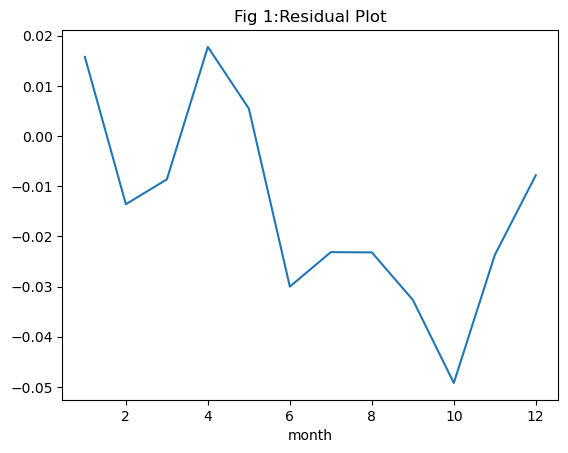

In [48]:
predictions = pd.DataFrame()
predictions['pr_observed'] = y_test
predictions['pr_predicted'] = y_pred
predictions['residuals'] = predictions['pr_observed'] - predictions['pr_predicted']
predictions['month'] = x_test['month']

predictions.groupby('month')['residuals'].mean().plot()
plt.title('Fig 1:Residual Plot')
plt.show()

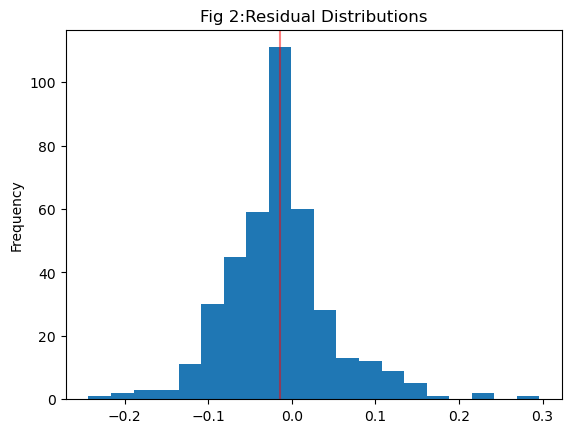

In [64]:
predictions['residuals'].plot.hist(bins=20)
plt.axvline(predictions['residuals'].mean(), color='red', alpha=0.5)
plt.title('Fig 2:Residual Distributions')
plt.show()

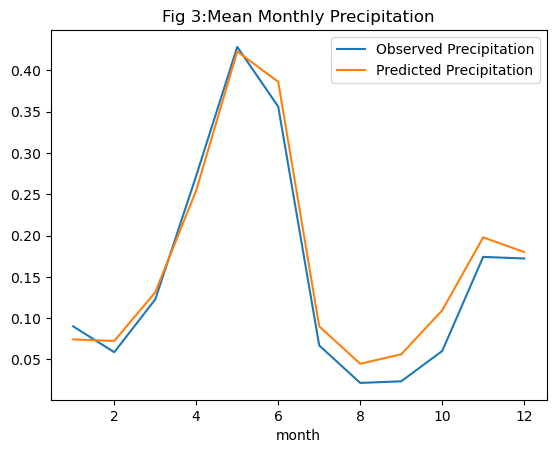

In [61]:
predictions.groupby('month')[['pr_observed','pr_predicted']].mean().plot()
plt.legend(['Observed Precipitation','Predicted Precipitation'])
plt.title('Fig 3:Mean Monthly Precipitation')
plt.show()

Before drawing any conclusions from our model, a thorough examination of the results is essential. Observing the mean monthly values for the target variable `pr` revealed discernible seasonality in Singapore's precipitation. Any model we develop must effectively capture this seasonal pattern in its predictions. Moreover, as we employed a regression model, assessing residuals over the same period is crucial for evaluating model performance.

To begin, let's analyze the residual plot, where residuals represent the disparity between observed and predicted values. Residuals for our model on the test data range between $0.02$ and $-0.05$, indicating a generally small difference between the two. However, a close-to-zero range alone doesn't guarantee a good model fit. Another critical aspect is the distribution of residuals. Linear regression assumes a normally distributed residual pattern. When plotting the distribution of all residuals in Figure 2, we notice that the mean of the residuals is slightly left of zero. This suggests that our model tends to predict values on the higher side compared to observed values. While this doesn't invalidate the model, it does introduce a level of uncertainty into its predictions.

Examining monthly precipitation—both observed and predicted—we observe that the model excels at predicting higher rainfall values during the rainy season but overestimates precipitation during drier periods. Despite not being an exceptional predictor overall, this model serves a valuable purpose beyond prediction. In the realm of regression, it provides insights into the significance of each predictor variable. Understanding the importance of attributes in our dataset can guide us in identifying the most significant factors impacting our target variable.


In [24]:
#best features
importances = final_model.get_feature_importance()
feature_names = x_train.columns.tolist()

feature_importance = dict(zip(feature_names,importances))
print('\n'.join(f'{key}: {value:.4f}' for key, value in feature_importance.items()))


tas: 9.5964
psl: 11.3704
huss: 14.6799
hurs: 29.0902
clt: 22.4827
month: 12.7804


Machine learning serves not only to forecast outcomes but also to uncover the primary variables influencing a specific result. In ensemble models, we examine coefficients across all variables or, in tree models, assess attribute usage frequency. Within our dataset spanning 1850 to 2014, attributes such as `hurs` (monthly mean relative humidity), `clt` (monthly mean total cloud cover), `huss` (monthly mean specific humidity), and `month` emerged as significant factors in predicting total monthly rainfall.

### Limitations and Final Remarks

It's crucial to acknowledge the inherent limitations of machine learning and the models we construct. While machine learning excels at detecting patterns within static data or a specific probability distribution, i.e assumes a constant environment, which may not align with the dynamic nature of weather and climate systems. Predictions generated by machine learning models are confined to the range of values within the training data. In the case of our regression model trained on data from 1850 to 2014, its applicability to periods beyond this range might be uncertain, given the atmosphere's dynamic nature.

This specific assumption, alongside the dynamic nature of the atmosphere, directed our choice of models. Each model class carries its own advantages and limitations, which necessitates careful consideration before initiating any machine learning project. We opted for gradient boosting models to address the evolving nature of the atmosphere driven by a changing climate. By iteratively improving predictions based on past errors, gradient boosting methods attempt to accommodate the dynamic structure of atmospheric data, leading to a more resilient model. Moreover, some models, like Linear Regression, may require data transformations which may potentially complicate interpretation of the final result.

Concluding, this tutorial aimed to provide a foundational understanding of constructing machine learning models. The key takeaway should center on mastering essential data preparation techniques, robust model evaluation strategies, and effective hyperparameter tuning. These skills will form the bedrock for your future pursuits in machine learning.